# EI balance in different CA1 neurons.

In [2]:
import sys
sys.path.append("../")
import glob
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
# print(plt.style.available)
plt.style.use('seaborn-white')
matplotlib.rcParams['font.family']
print(findfont(FontProperties(family=['sans-serif'])))

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf


In [3]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [5]:
voltageClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [9]:
with open (voltageClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [10]:
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

In [13]:
feature = 0
scalingFactor = 1e9
neurons = []
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    neurons.append(Neuron.load(filename))

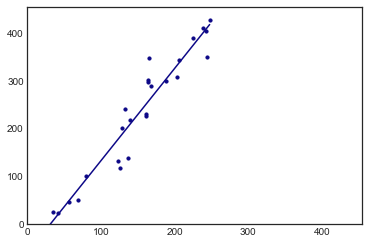

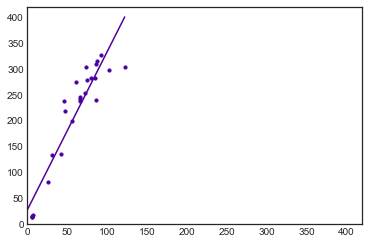

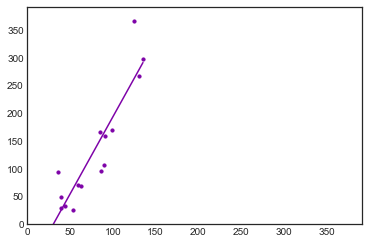

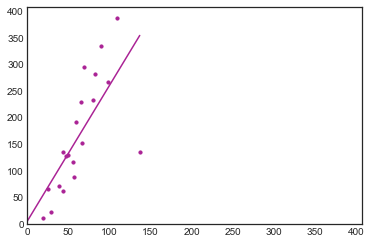

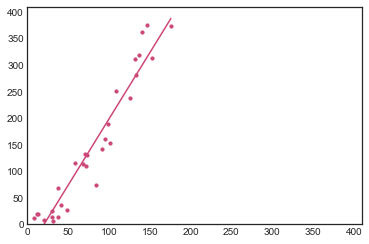

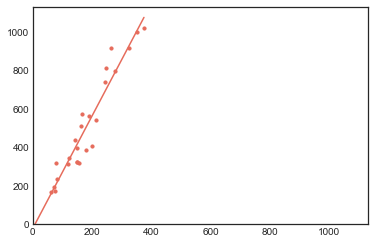

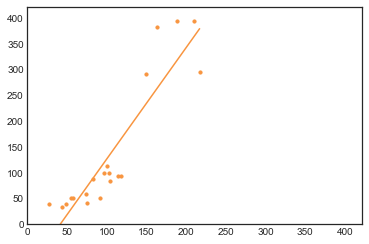

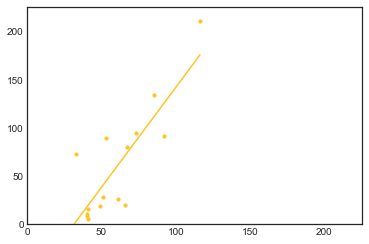

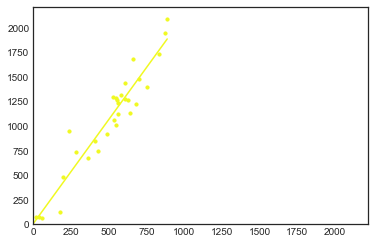

In [20]:
r_squared = []
slopes = []
for index, n in enumerate(neurons):
#     if index != (len(neurons) - 1) and index != (len(neurons) - 3) :
        obs_exc, obs_inh = {}, {}
        sqrs = []
        f, ax = plt.subplots()
        for expt in n:
            for sqr in expt:
                if (expt[sqr].type == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]
                elif (expt[sqr].type == 2):
                    for coord in expt[sqr].coordwise:
                        obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]

        exc, inh = [], []
        for coord in set(obs_exc).intersection(set(obs_inh)):
            exc.append(-obs_exc[coord]*scalingFactor)
            inh.append(obs_inh[coord]*scalingFactor)
            ax.scatter(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, c=color_cell[index], s=10)
        
        slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)
        r_squared.append(rval**2)
        slopes.append(slope)

        excRange = np.linspace(0, max(exc), 100)
        inhFit = excRange*slope + intercept

        ax.plot(excRange, inhFit, c=color_cell[index])
        xlim_old = ax.get_xlim()
        ylim_old = ax.get_ylim()
        minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
        ax.set_xlim(0,maxlim)
        ax.set_ylim(0,maxlim)
        plt.show()

# ax.set_title("Linear regression showing proportional E and I")
# ax.set_xlabel("")
# ax.set_ylabel("")
#plt.legend(scatterPoints=sqrs, label=sqrs)


## Figure 2 C (Example Cell)

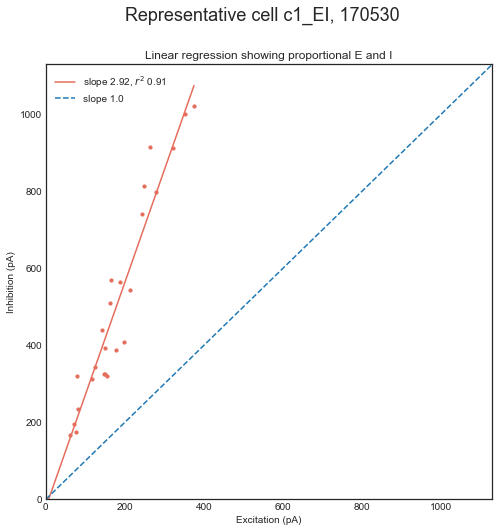

In [23]:
index = -4
n = neurons[index]
obs_exc, obs_inh = {}, {}
sqrs = []
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
f.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
for expt in n:
    for sqr in expt:
        if (expt[sqr].type == 1):
            sqrs.append(sqr)
            for coord in expt[sqr].coordwise:
                obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]
        elif (expt[sqr].type == 2):
            for coord in expt[sqr].coordwise:
                obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]

exc, inh = [], []
for coord in set(obs_exc).intersection(set(obs_inh)):
    exc.append(-obs_exc[coord]*scalingFactor)
    inh.append(obs_inh[coord]*scalingFactor)
    ax.scatter(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, c=color_cell[index], s=10)

slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

excRange = np.linspace(0, max(exc), 100)
inhFit = excRange*slope + intercept

ax.plot(excRange, inhFit, c=color_cell[index], label="slope {:.2f}, $r^2$ {:.2f}".format(slope, rval**2))
xlim_old = ax.get_xlim()
ylim_old = ax.get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax.plot((0,maxlim), (0,maxlim),'--', label="slope 1.0")
ax.set_xlim(0,maxlim)
ax.set_ylim(0,maxlim)
ax.set_title("Linear regression showing proportional E and I")
ax.set_xlabel("Excitation (pA)")
ax.set_ylabel("Inhibition (pA)")
plt.legend()
plt.show()

## Figures 2 D, E (Statistics)

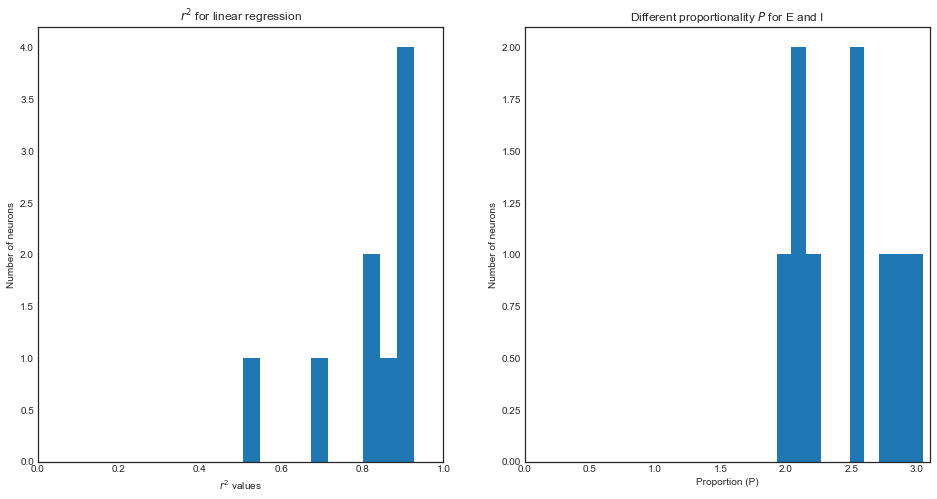

In [24]:
f, ax = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(16)
ax[0].hist(r_squared)
ax[0].set_title("$r^2$ for linear regression")
ax[0].set_xlabel("$r^2$ values")
ax[0].set_ylabel("Number of neurons")
ax[0].set_xlim((0,1))

ax[1].hist(slopes)
ax[1].set_title("Different proportionality $P$ for E and I")
ax[1].set_xlabel("Proportion (P)")
ax[1].set_ylabel("Number of neurons")
ax[1].set_xlim(xmin=0)
plt.show()

In [25]:
np.mean(r_squared), np.std(r_squared)

(0.819584047985082, 0.13179758506026726)

## Figure 2 F: r-square and I/E changes with number of squares

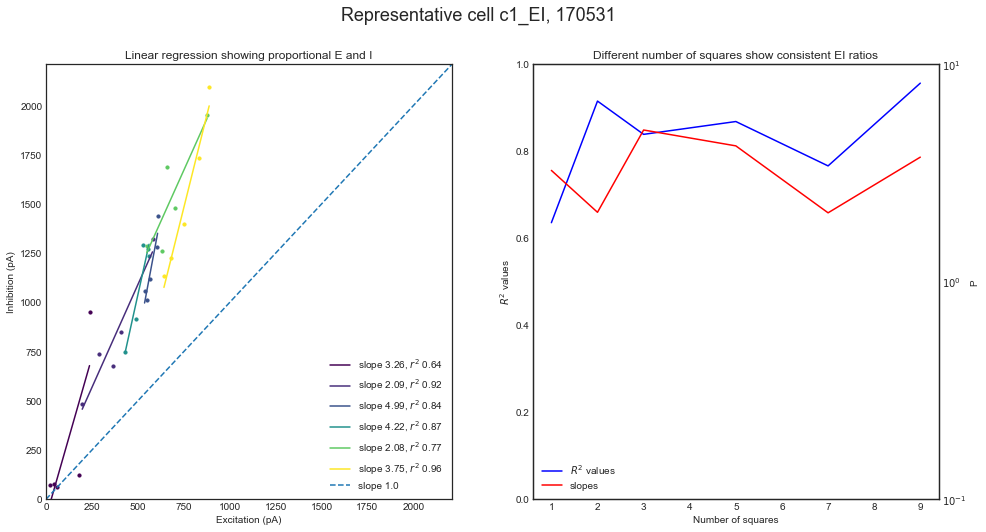

In [29]:
r_squared = []
slopes = []
index = -1
n = neurons[index]
obs_exc, obs_inh = {}, {}
sqrs = {}

f, ax = plt.subplots(1, 2)
f.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
f.set_figheight(8)
f.set_figwidth(16)
r_sqrs, slopes, sqrs = [], [], []

for sqr in set(n.experiment[1]).intersection(set(n.experiment[2])):
    exc, inh = [], []
    for coord in set(n.experiment[1][sqr].coordwise).intersection(set(n.experiment[1][sqr].coordwise)):
        exc.append(-n.experiment[1][sqr].coordwise[coord].average_feature[5]*scalingFactor)
        inh.append(n.experiment[2][sqr].coordwise[coord].average_feature[0]*scalingFactor)
    ax[0].scatter(exc, inh, c=color_sqr[sqr], s=10)

    slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

    excRange = np.linspace(min(exc), max(exc), 100)
    inhFit = excRange*slope + intercept

    ax[0].plot(excRange, inhFit, c=color_sqr[sqr], label="slope {:.2f}, $r^2$ {:.2f}".format(slope, rval**2))
    sqrs.append(sqr)
    slopes.append(slope)
    r_sqrs.append(rval**2)

xlim_old = ax[0].get_xlim()
ylim_old = ax[0].get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax[0].plot((0,maxlim), (0,maxlim),'--', label="slope 1.0")
ax[0].set_xlim(0,maxlim)
ax[0].set_ylim(0,maxlim)
ax[0].set_title("Linear regression showing proportional E and I")
ax[0].set_xlabel("Excitation (pA)")
ax[0].set_ylabel("Inhibition (pA)")
ax[0].legend()

line1 = ax[1].plot(sqrs, r_sqrs, label="$R^2$ values",c='b')
ax[1].set_ylim((0,1))
ax_copy = ax[1].twinx()
line2 = ax_copy.plot(sqrs, slopes, label="slopes",c='r')
ax[1].set_title("Different number of squares show consistent EI ratios")
ax[1].set_xlabel("Number of squares")
ax[1].set_ylabel("$R^2$ values")
ax_copy.set_ylim((0.1,10))
ax_copy.set_ylabel("P")
ax_copy.set_yscale("log")

lines = line1+line2
labs = [l.get_label() for l in lines]
ax[1].legend(lines, labs, loc=0)
plt.show()

    A. shows tight balance between tight balance between excitation and inhibition at the CA1 neuron. 
    B. shows r-square for linear regression showing high degree of correlation between E and I. 
    C. showing different proportionality P of all CA1 neurons.